# Quantum Neural Networks!

We are now ready to implement and train our first quantum neural network with PennyLane. The PennyLane framework is great for many applications, but it shines the most when it comes to the implementation of quantum neural network models. This is all due to its flexibility and good integration with classical machine learning frameworks. We, in particular, are going to be using PennyLane in conjunction with TensorFlow to train a QNN-based binary classifier.

This example will start by following the demonstration from [PennyLane](https://pennylane.ai/qml/demos/tutorial_qnn_module_tf) which is a fantastic resource for quantum computing information and examples.


### Installing the required libraries and setting up the environment

here I am using tensorflow==2.13.1 and pennylane==0.26 for this project. These have both had numerous updates so be aware the the code may not work with other versions.

We begin by importing PennyLane, NumPy, and TensorFlow and setting some seeds for these packages, just to make sure that our results are reproducible.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import pennylane as qml

In [2]:
print(tf.__version__)

2.14.0


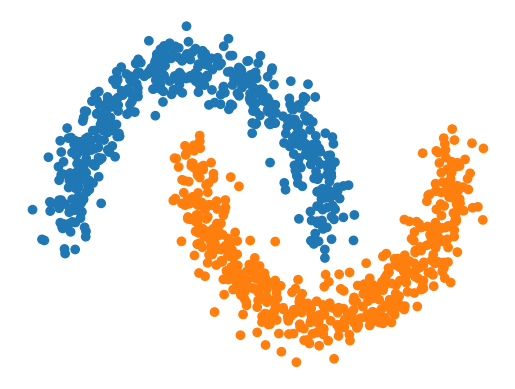

In [3]:
# Set random seeds
np.random.seed(666)
tf.random.set_seed(666)

X, y = make_moons(n_samples=1000, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Our next step is to define the QNode that we want to interface with Keras. Any combination of device, operations and measurements that is valid in PennyLane can be used to compose the QNode. However, the QNode arguments must satisfy additional conditions including having an argument called inputs. All other arguments must be arrays or tensors and are treated as trainable weights in the model. We fix a two-qubit QNode using the default.qubit simulator and operations from the templates module.

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

With the QNode defined, we are ready to interface with Keras. This is achieved using the KerasLayer class of the qnn module, which converts the QNode to the elementary building block of Keras: a layer. We shall see in the following how the resultant layer can be combined with other well-known neural network layers to form a hybrid model.

We must first define the weight_shapes dictionary. Recall that all of the arguments of the QNode (except the one named inputs) are treated as trainable weights. For the QNode to be successfully converted to a layer in Keras, we need to provide the details of the shape of each trainable weight for them to be initialized. The weight_shapes dictionary maps from the argument names of the QNode to corresponding shapes:

In [5]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In our example, the weights argument of the QNode is trainable and has shape given by `(n_layers, n_qubits)`, which is passed to `BasicEntanglerLayers().`

Now that weight_shapes is defined, it is easy to then convert the QNode:

In [6]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

Let’s create a basic three-layered hybrid model consisting of:

1. a 2-neuron fully connected classical layer
2. our 2-qubit QNode converted into a layer
3. another 2-neuron fully connected classical layer
4. a softmax activation to convert to a probability vector

In [7]:
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])

We can now train our hybrid model on the classification dataset using the usual Keras approach. We’ll use the standard SGD optimizer and the mean absolute error loss function:

In [8]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

Note that there are more advanced combinations of optimizer and loss function, but here we are focusing on the basics.

The model is now ready to be trained!

In [9]:
fitting = model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/6
150/150 - 8s - loss: 0.2418 - accuracy: 0.7973 - val_loss: 0.1655 - val_accuracy: 0.8720 - 8s/epoch - 54ms/step
Epoch 2/6
150/150 - 8s - loss: 0.1508 - accuracy: 0.8787 - val_loss: 0.1870 - val_accuracy: 0.8440 - 8s/epoch - 54ms/step
Epoch 3/6
150/150 - 8s - loss: 0.1403 - accuracy: 0.8773 - val_loss: 0.1305 - val_accuracy: 0.8760 - 8s/epoch - 54ms/step
Epoch 4/6
150/150 - 8s - loss: 0.1370 - accuracy: 0.8680 - val_loss: 0.1438 - val_accuracy: 0.8640 - 8s/epoch - 55ms/step
Epoch 5/6
150/150 - 8s - loss: 0.1429 - accuracy: 0.8680 - val_loss: 0.1259 - val_accuracy: 0.8800 - 8s/epoch - 54ms/step
Epoch 6/6
150/150 - 9s - loss: 0.1327 - accuracy: 0.8720 - val_loss: 0.1472 - val_accuracy: 0.8760 - 9s/epoch - 57ms/step


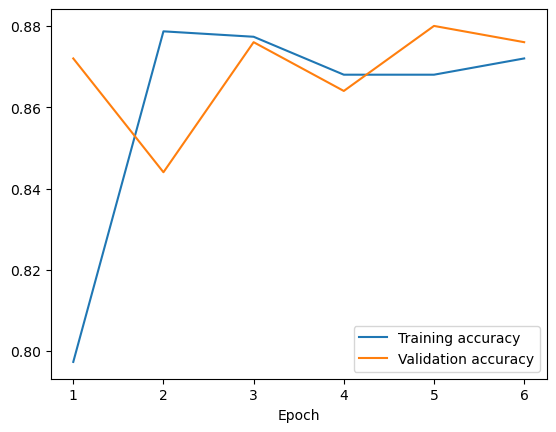

In [10]:
def plot_losses(history):
    tr_loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training accuracy")
    plt.plot(epochs, val_loss, label = "Validation accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(fitting)

## and now for some HEP data

Here we aim to investigate the embeddings available to classify high energy physics data in which the input features are descriptive of the event topology. The example dataset being used will be the Kaggle Higgs Boson challenge dataset. The dataset is a binary classification problem in which the goal is to classify events as either signal (Higgs Boson) or background. The dataset contains 30 features, 22 of which are low-level features and 13 of which are high-level features. The low-level features are derived from the raw data and are used to describe the event topology. The high-level features are derived from the low-level features and are used to describe the event topology in a more abstract way. 

In [11]:
import pandas as pd

In [12]:
# Load the data
train_data = pd.read_csv('./processed_ALL.csv')[:1000]
# Split features and labels
x = train_data.drop(columns=['Weight','Label'])
y = train_data['Label']

In [13]:
x.describe()

DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis     DER_pt_h  \
count   1000.000000                  1000.000000   1000.000000  1000.000000   
mean      -0.050736                     0.009299     -0.060139     0.019274   
std        0.928516                     1.028851      0.887677     1.013090   
min       -1.740317                    -1.146187     -1.599097    -1.402713   
25%       -0.514154                    -0.745025     -0.562286    -0.682638   
50%       -0.190806                    -0.262644     -0.221536    -0.176975   
75%        0.146179                     0.564656      0.202928     0.451808   
max        9.265424                    12.414870      6.844305     5.764864   

       DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
count           1000.000000       1000.000000          1000.000000   
mean              -0.041527         -0.016736             0.072512   
std                0.983253          1.074583             1.020833   
min               -1.389873         -0.896675            -3.982627   
25%               -0.900494         -0.680120            -0.446468   
50%               -0.199197         -0.420924             0.204036   
75%                0.651469          0.174824             0.562273   
max                3.078659          7.376486             3.799763   

       DER_deltar_tau_lep   DER_pt_tot   DER_sum_pt  ...  PRI_met_phi  \
count         1000.000000  1000.000000  1000.000000  ...  1000.000000   
mean            -0.052590     0.006855    -0.012779  ...    -0.002896   
std              0.980028     0.912223     0.993185  ...     1.016567   
min             -2.004213    -0.959703    -1.276559  ...    -1.729436   
25%             -0.809127    -0.792811    -0.696991  ...    -0.852448   
50%             -0.149780    -0.120270    -0.301903  ...    -0.059534   
75%              0.680616     0.414440     0.382792  ...     0.894361   
max              3.644933     5.218661     5.445039  ...     1.727796   

       PRI_met_sumet  PRI_jet_num  PRI_jet_leading_pt  PRI_jet_leading_eta  \
count    1000.000000  1000.000000         1000.000000          1000.000000   
mean        0.020754     0.026722           -0.018222             0.044690   
std         0.991488     1.011495            0.997347             0.998203   
min        -1.897077    -0.660444           -1.117385            -2.503513   
25%        -0.644770    -0.660444           -0.695309            -0.701265   
50%        -0.222671    -0.660444           -0.316355             0.043684   
75%         0.451463     1.514133            0.314808             0.830146   
max         5.635860     1.514133            5.030621             2.273662   

       PRI_jet_leading_phi  PRI_jet_subleading_pt  PRI_jet_subleading_eta  \
count          1000.000000            1000.000000             1000.000000   
mean              0.016744              -0.012011                0.038690   
std               0.987086               1.021177                1.009116   
min              -1.716410              -0.865856               -2.188826   
25%              -0.793658              -0.668209               -0.761146   
50%               0.020762              -0.328603                0.080199   
75%               0.842505               0.249715                0.873966   
max               1.739141               9.367639                2.188269   

       PRI_jet_subleading_phi  PRI_jet_all_pt  
count             1000.000000     1000.000000  
mean                -0.005650       -0.011340  
std                  0.983263        0.994887  
min                 -1.720867       -1.126881  
25%                 -0.843847       -0.692695  
50%                 -0.054048       -0.306833  
75%                  0.831914        0.366983  
max                  1.724480        5.781434  

[8 rows x 30 columns]

In [14]:
from sklearn.model_selection import train_test_split

x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [15]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
#x_tr = scaler.fit_transform(x_tr)
#x_test = scaler.transform(x_test)
#x_val = scaler.transform(x_val)

In [17]:
# Restrict all the values to be between 0 and 1.
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)
y_hot_tr = tf.keras.utils.to_categorical(y_tr, num_classes=2)  # one-hot encoded labels
y_hot_test = tf.keras.utils.to_categorical(y_test, num_classes=2)  # one-hot encoded labels
y_hot_val = tf.keras.utils.to_categorical(y_val, num_classes=2)  # one-hot encoded labels

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

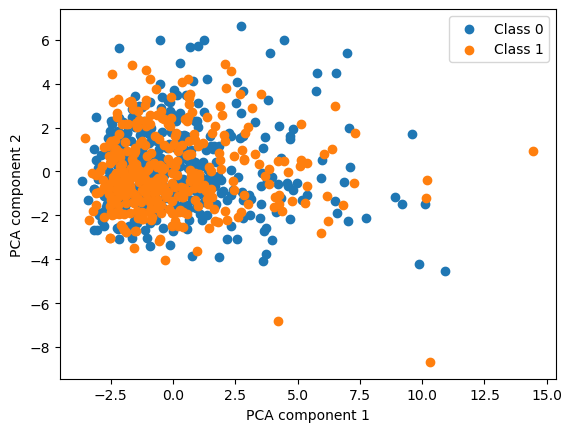

In [19]:
plt.scatter(xs_tr[y_tr == 0, 0], xs_tr[y_tr == 0, 1], label = "Class 0")
plt.scatter(xs_tr[y_tr == 1, 0], xs_tr[y_tr == 1, 1], label = "Class 1")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend()

In [20]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [21]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [22]:
clayer_1 = tf.keras.layers.Dense(4)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss="mae", metrics=["accuracy"])

In [24]:
history = model.fit(xs_tr, y_hot_tr, epochs=6, batch_size=5, validation_data=(xs_val,y_hot_val), verbose=2)

Epoch 1/6
160/160 - 17s - loss: 0.4870 - accuracy: 0.5288 - val_loss: 0.4175 - val_accuracy: 0.6000 - 17s/epoch - 106ms/step
Epoch 2/6
160/160 - 17s - loss: 0.4740 - accuracy: 0.5387 - val_loss: 0.4088 - val_accuracy: 0.6200 - 17s/epoch - 107ms/step
Epoch 3/6
160/160 - 17s - loss: 0.4554 - accuracy: 0.5550 - val_loss: 0.4007 - val_accuracy: 0.6200 - 17s/epoch - 106ms/step
Epoch 4/6
160/160 - 17s - loss: 0.4497 - accuracy: 0.5650 - val_loss: 0.3846 - val_accuracy: 0.6200 - 17s/epoch - 107ms/step
Epoch 5/6
160/160 - 17s - loss: 0.4400 - accuracy: 0.5875 - val_loss: 0.3858 - val_accuracy: 0.6100 - 17s/epoch - 105ms/step
Epoch 6/6
160/160 - 17s - loss: 0.4386 - accuracy: 0.5800 - val_loss: 0.3812 - val_accuracy: 0.6400 - 17s/epoch - 105ms/step


In [25]:
from sklearn.metrics import accuracy_score

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_hot_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_hot_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_hot_test)

print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

4/4 [==============================] - 0s 43ms/step
Train accuracy: 0.59625
Validation accuracy: 0.64
Test accuracy: 0.53
